In [1]:
from scipy.stats import entropy
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
from tqdm import tqdm
import sys
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from plot import *
import importlib

importlib.reload(sys.modules['plot'])
from plot import *

In [2]:
###to calculate and plot peaks for individual kmers from the signal distributions
kmerpeaks = {}
for line in open('../data/uncalled_eventalign/220308_ang_500_sig_dist_precalculated_hist.tsv'):
    line = line.rstrip().split('\t')
    hist = [float(x) for x in line[1].split(',')]
    if line[0] not in kmerpeaks: kmerpeaks[line[0]] = [hist]
    else: kmerpeaks[line[0]].append(hist)
for line in open('../data/uncalled_eventalign/220308_ang_0_sig_dist_precalculated_hist.tsv'):
    line = line.rstrip().split('\t')
    hist = [float(x) for x in line[1].split(',')]
    if line[0] not in kmerpeaks: kmerpeaks[line[0]] = [hist]
    else: kmerpeaks[line[0]].append(hist)

GTATCC
1 1


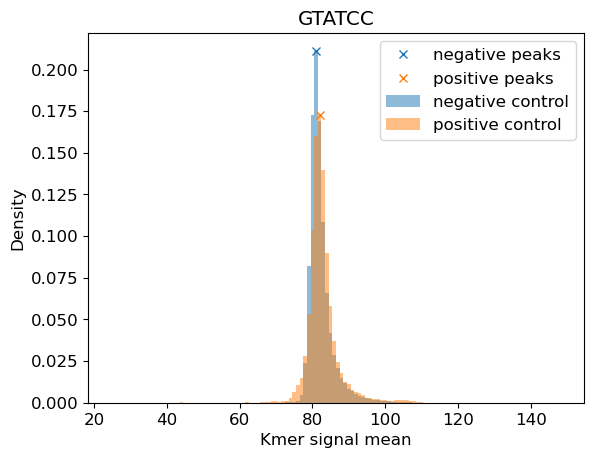

In [4]:
for kmer in ['GTATCC']:
    print(kmer)
    pos, neg = kmerpeaks[kmer]
    pospeaks, _ = find_peaks(pos, prominence=0.005, distance=5)
    negpeaks, _ = find_peaks(neg, prominence=0.005, distance=5)
    print(len(pospeaks), len(negpeaks))
    plt.figure()
    plt.bar(range(25,149), neg, width=1, label="negative control", alpha=0.5)
    plt.bar(range(25, 149), pos, width=1, label="positive control", alpha=0.5)
    plt.plot([x+25 for x in negpeaks], [neg[x] for x in negpeaks], 'x', label='negative peaks')
    plt.plot([x+25 for x in pospeaks], [pos[x] for x in pospeaks], 'x', label='positive peaks')
    plt.xlabel('Kmer signal mean')
    plt.ylabel('Density')
    plt.title(kmer)
    plt.legend()
    plt.savefig("../figures/Figure_revision_500_angelicin_ctrl_sig_dist_" + kmer + "_withpeaks.pdf", dpi=600)

## missing k-mer analysis

In [9]:
genome = {}
last = None
for line in open('../../Add-seq/data/ref/sacCer3.fa'):
    if line[0] == '>':
        last = line[1:].rstrip()
        genome[last] = ''
    else: genome[last] += line.rstrip()
print('loaded genome')

loaded genome


In [7]:
negcollapsefile = '../../Add-seq/data/ctrl/pod5/nanocompore/220308_ang_0_eventalign_collapse.tsv'
poscollapsefile = '../../Add-seq/data/ctrl/pod5/nanocompore/220308_ang_500_eventalign_collapse.tsv'

In [10]:
kmerToMeds, kmerToMissing = {}, {}
allmeds = []
last = None
lastkmer = None
readname, chr = None, None

for line in open(poscollapsefile):
    if line[0] == '#':
        last = None
        # print(line)
        if len(line.split()) == 2:
            readname, chr = line[1:].rstrip().split()
        continue
    line = line.rstrip().split('\t')
    if line[0] == 'ref_pos': continue
    kmer = line[1]
    if kmer not in kmerToMeds:
        kmerToMeds[kmer] = []
        # [missed occurance, total occurance]
        kmerToMissing[kmer] = [0,0]
    median = float(line[-2])
    refpos = int(line[0])
    
    if last and last != refpos-1:
        for i in range(last+1, refpos):
            missedkmer = genome[chr][i:i+6]
            if missedkmer not in kmerToMissing: kmerToMissing[missedkmer] = [0,0]
            kmerToMissing[missedkmer][0] += 1
            kmerToMissing[missedkmer][1] += 1
    last = refpos
    lastkmer = kmer
    kmerToMissing[kmer][1] += 1
    kmerToMeds[kmer].append(median)

outmissing = open('../../Add-seq/data/ctrl/pod5/nanocompore/220308_ang_500_eventalign_nanocompore_collapse_missingbykmer.tsv', 'w')
for kmer in kmerToMissing:
    fracmissing = kmerToMissing[kmer][0]/kmerToMissing[kmer][1]
    outmissing.write('\t'.join([str(x) for x in [kmer, kmerToMissing[kmer][0], kmerToMissing[kmer][1], fracmissing]]) + '\n')

In [11]:
kmerToMeds, kmerToMissing = {}, {}
allmeds = []
last = None
lastkmer = None
readname, chr = None, None

for line in open(negcollapsefile):
    if line[0] == '#':
        last = None
        # print(line)
        if len(line.split()) == 2:
            readname, chr = line[1:].rstrip().split()
        continue
    line = line.rstrip().split('\t')
    if line[0] == 'ref_pos': continue
    kmer = line[1]
    if kmer not in kmerToMeds:
        kmerToMeds[kmer] = []
        # [missed occurance, total occurance]
        kmerToMissing[kmer] = [0,0]
    median = float(line[-2])
    refpos = int(line[0])
    
    if last and last != refpos-1:
        for i in range(last+1, refpos):
            missedkmer = genome[chr][i:i+6]
            if missedkmer not in kmerToMissing: kmerToMissing[missedkmer] = [0,0]
            kmerToMissing[missedkmer][0] += 1
            kmerToMissing[missedkmer][1] += 1
    last = refpos
    lastkmer = kmer
    kmerToMissing[kmer][1] += 1
    kmerToMeds[kmer].append(median)

outmissing = open('../../Add-seq/data/ctrl/pod5/nanocompore/220308_ang_0_eventalign_nanocompore_collapse_missingbykmer.tsv', 'w')
for kmer in kmerToMissing:
    fracmissing = kmerToMissing[kmer][0]/kmerToMissing[kmer][1]
    outmissing.write('\t'.join([str(x) for x in [kmer, kmerToMissing[kmer][0], kmerToMissing[kmer][1], fracmissing]]) + '\n')
outmissing.close()

In [25]:
kmerToSampleToMissing = {}
bins = np.arange(0,200,0.1)
states = ['0', '500']
for ang in states:
    for line in open('../../Add-seq/data/ctrl/pod5/nanocompore/220308_ang_' + ang + '_eventalign_nanocompore_collapse_missingbykmer.tsv'):
        line = line.rstrip().split('\t')
        kmer = line[0]
        fracmissing = float(line[-1])
        if kmer not in kmerToSampleToMissing: kmerToSampleToMissing[kmer] = {}
        kmerToSampleToMissing[kmer][ang] = fracmissing
    print('loaded', ang)

loaded 0
loaded 500


In [16]:
informative_kmers = []
with open('../data/uncalled_eventalign/5_500_angelicin_informative_kmers.tsv', 'r') as infile:
    for line in infile:
        line = line.strip().split('\t')
        informative_kmers.append(line[0])

In [19]:
non_informative_kmers = []
with open('../data/uncalled_eventalign/5_500_angelicin_non_informative_kmers.tsv', 'r') as infile:
    for line in infile:
        line = line.strip().split('\t')
        non_informative_kmers.append(line[0])

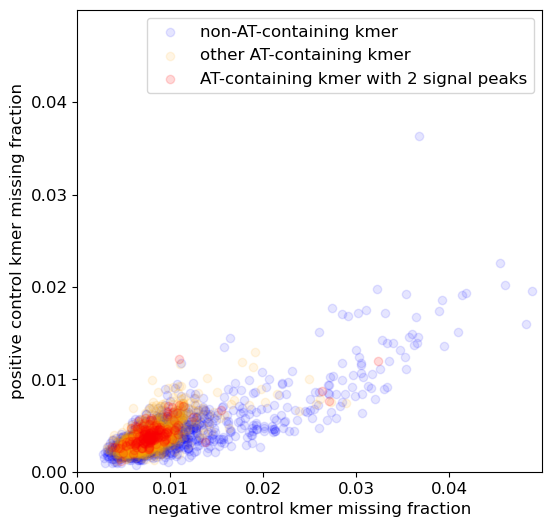

In [29]:
atkmermissingxy, nonatkmermissingxy = [[], []], [[], []]
kmerwith2peaksmissingxy = [[], []]
for kmer in informative_kmers + non_informative_kmers:
    for i in range(2):
        ang = states[i]
        thisfrac = kmerToSampleToMissing[kmer][ang]
        if kmer in informative_kmers:
            kmerwith2peaksmissingxy[i].append(thisfrac)
        elif 'AT' in kmer or 'TA' in kmer:
            atkmermissingxy[i].append(thisfrac)
        else:
            nonatkmermissingxy[i].append(thisfrac)
##plot missingness of AT and non-AT kmers
fig, ax = plt.subplots(figsize=(6, 4))
fig.set_size_inches(6,6)
ax.scatter(nonatkmermissingxy[0], nonatkmermissingxy[1], color='blue', alpha=0.1, label='non-AT-containing kmer')
ax.scatter(atkmermissingxy[0], atkmermissingxy[1], color='orange', alpha=0.1, label='other AT-containing kmer')
ax.scatter(kmerwith2peaksmissingxy[0], kmerwith2peaksmissingxy[1], color='red', alpha=0.15, label='AT-containing kmer with 2 signal peaks')
plt.xlim((0,0.05))
plt.ylim((0,0.05))
ax.set_xticks(np.arange(0, 0.05, 0.01))
ax.set_yticks(np.arange(0, 0.05, 0.01))
plt.xlabel('negative control kmer missing fraction')
plt.ylabel('positive control kmer missing fraction')
plt.legend()
plt.savefig('../figures/Figure_revision_missing_kmer.pdf', dpi=600)

In [ ]:
atkmermissingxy, nonatkmermissingxy = [[], []], [[], []]
kmerwith2peaksmissingxy = [[], []]
for kmer in informative_kmers + non_informative_kmers:
    for i in range(2):
        ang = states[i]
        thisfrac = kmerToSampleToMissing[kmer][ang]
        if kmer in informative_kmers:
            kmerwith2peaksmissingxy[i].append(thisfrac)
        elif 'AT' in kmer or 'TA' in kmer:
            atkmermissingxy[i].append(thisfrac)
        else:
            nonatkmermissingxy[i].append(thisfrac)
##plot missingness of AT and non-AT kmers
fig, ax = plt.subplots(figsize=(6, 4))
fig.set_size_inches(6,6)
ax.scatter(nonatkmermissingxy[0], nonatkmermissingxy[1], color='blue', alpha=0.1, label='non-AT-containing kmer')
ax.scatter(atkmermissingxy[0], atkmermissingxy[1], color='orange', alpha=0.1, label='other AT-containing kmer')
ax.scatter(kmerwith2peaksmissingxy[0], kmerwith2peaksmissingxy[1], color='red', alpha=0.15, label='AT-containing kmer with 2 signal peaks')
plt.xlim((0,0.35))
plt.ylim((0,0.35))
ax.set_xticks([0,0.1,0.2,0.3])
ax.set_yticks([0,0.1,0.2,0.3])
plt.xlabel('negative control kmer missing fraction')
plt.ylabel('positive control kmer missing fraction')
plt.legend()
plt.savefig('../figures/Figure_revision_missing_kmer_original_scale.pdf', dpi=600)